In [6]:
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np

col_names = np.loadtxt('./col_names.txt', dtype='str')
data = pd.read_csv('KDDTest+.csv', header=None, names=col_names)

In [12]:
df = spark.createDataFrame(data)
#should probably normalize here

#one-hot-encode cols 1-3
one_hot_cols = ['protocol_type', 'service', 'flag']

In [ ]:
#df = spark.read.csv('KDDTest+.csv')
#df = spark.createDataFrame(data)

In [13]:

from pyspark.ml.feature import OneHotEncoder, StringIndexer
df_one_hot = df
for label in one_hot_cols:
    stringIndexer = StringIndexer(inputCol=label, outputCol=label+"_index")
    model = stringIndexer.fit(df_one_hot)
    indexed = model.transform(df_one_hot)

    encoder = OneHotEncoder(inputCol=label+"_index", outputCol=label+"_vec")
    encoded = encoder.transform(indexed)
    df_one_hot = encoder.transform(indexed).drop(label+"_index").drop(label)

In [14]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

df_non_null = df_one_hot.fillna(0)

feature_labels = ['label', 'index_label']
feature_names = [x for x in df_one_hot.columns if x not in feature_labels]
print(len(feature_names))

vecAssembler = VectorAssembler(inputCols=feature_names, outputCol="features")
vector_features = vecAssembler.transform(df_non_null).drop(*feature_names)

41


In [7]:
vector_features.first()

Row(label='neptune', index_label=21, features=SparseVector(112, {19: 229.0, 20: 10.0, 23: 1.0, 24: 1.0, 25: 0.04, 26: 0.06, 28: 255.0, 29: 10.0, 30: 0.04, 31: 0.06, 36: 1.0, 37: 1.0, 38: 1.0, 41: 1.0, 103: 1.0}))

In [8]:
vector_features.select('index_label').distinct().count()

22

In [9]:
#load data
#df = dataset.load()

seed = 1024
num_clusters = vector_features.select('index_label').distinct().count() #22
num_steps = 21
batch_size = 1024
num_features = 41

kmeans = KMeans().setK(num_clusters).setSeed(seed)
kmeansmodel = kmeans.fit(vector_features)

sse = kmeansmodel.computeCost(vector_features)
print("Sum of Squared Errors = " + str(sse))

centers = kmeansmodel.clusterCenters()
print ("Cluster Centers: ")
for center in centers:
    print(center)
    
    

Sum of Squared Errors = 542853923909.0288
Cluster Centers: 
[1.98623681e+02 2.70150765e+02 9.48134895e+02 3.32604771e-04
 9.02784377e-03 2.85089803e-04 7.53587380e-02 2.30922741e-02
 4.16468688e-01 5.03658652e-03 1.71053882e-03 4.75149672e-05
 4.75149672e-03 8.07754443e-03 8.55269410e-04 3.04095790e-03
 0.00000000e+00 5.22664639e-04 3.04570940e-02 8.37496436e+01
 3.23129811e+01 1.09215053e-01 1.09988596e-01 2.32434667e-01
 2.29133327e-01 7.21985650e-01 1.00588235e-01 1.00472774e-01
 1.94873658e+02 1.36539913e+02 5.87001330e-01 9.54818018e-02
 1.30241851e-01 1.89489689e-02 1.04279198e-01 1.05815357e-01
 2.41710064e-01 2.34547182e-01 8.27093034e-01 1.24489214e-01
 3.18017676e-01 2.26788939e-01 7.56438278e-02 4.84177516e-02
 4.39038297e-02 4.24783807e-02 2.83189205e-02 3.98175425e-02
 3.51135608e-02 3.28803573e-02 1.45395800e-02 1.19262568e-02
 7.55487979e-03 6.46203554e-03 3.18350280e-03 2.42326333e-03
 2.37574836e-03 2.28071843e-03 2.18568849e-03 2.18568849e-03
 2.13817352e-03 2.0431435

In [10]:
transformed = kmeansmodel.transform(vector_features)
#.select("features","prediction", "index_label")
transformed.collect()

[Row(label='neptune', index_label=21, features=SparseVector(112, {19: 229.0, 20: 10.0, 23: 1.0, 24: 1.0, 25: 0.04, 26: 0.06, 28: 255.0, 29: 10.0, 30: 0.04, 31: 0.06, 36: 1.0, 37: 1.0, 38: 1.0, 41: 1.0, 103: 1.0}), prediction=0),
 Row(label='neptune', index_label=21, features=SparseVector(112, {19: 136.0, 20: 1.0, 23: 1.0, 24: 1.0, 25: 0.01, 26: 0.06, 28: 255.0, 29: 1.0, 31: 0.06, 36: 1.0, 37: 1.0, 38: 1.0, 41: 1.0, 103: 1.0}), prediction=0),
 Row(label='normal', index_label=21, features=SparseVector(112, {0: 2.0, 1: 12983.0, 19: 1.0, 20: 1.0, 25: 1.0, 28: 134.0, 29: 86.0, 30: 0.61, 31: 0.04, 32: 0.61, 33: 0.02, 38: 1.0, 46: 1.0, 102: 1.0}), prediction=0),
 Row(label='saint', index_label=15, features=SparseVector(112, {1: 20.0, 19: 1.0, 20: 65.0, 25: 1.0, 27: 1.0, 28: 3.0, 29: 57.0, 30: 1.0, 32: 1.0, 33: 0.28, 51: 1.0, 102: 1.0}), prediction=0),
 Row(label='mscan', index_label=11, features=SparseVector(112, {0: 1.0, 2: 15.0, 19: 1.0, 20: 8.0, 22: 0.12, 23: 1.0, 24: 0.5, 25: 1.0, 27: 0.7

In [41]:
label_prediction_agg_pd = transformed.groupBy("index_label", "prediction").count().sort("count").toPandas()
label_agg_pd = transformed.groupBy("index_label").count().sort("count").toPandas()
prediction_agg_pd = transformed.groupBy("prediction").count().sort("count").toPandas()



In [ ]:
y_pos = np.arange(len(label_prediction_agg_pd['index_label']))

series1 = label_prediction_agg_pd['index_label']
series2 = label_prediction_agg_pd['prediction']
yvals = label_prediction_agg_pd['count']

In [72]:
label_prediction_agg_pd

,index_label,prediction,count
0,13,14,1
1,21,19,1
2,19,11,1
3,13,15,1
4,9,19,1
5,9,6,1
6,18,21,1
7,3,6,1
8,7,8,1
9,20,4,1


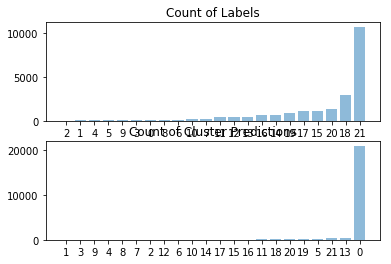

In [69]:
import numpy as np
import matplotlib.pyplot as plt



y_pos = np.arange(len(label_agg_pd['index_label']))

plt.subplot(2,1,1)
plt.bar(y_pos, label_agg_pd['count'], align='center', alpha=0.5)
plt.xticks(y_pos, label_agg_pd['index_label'])
plt.title('Count of Labels')

plt.subplot(2,1,2)
plt.bar(y_pos, prediction_agg_pd['count'], align='center', alpha=0.5)
plt.xticks(y_pos, prediction_agg_pd['prediction'])
plt.title('Count of Cluster Predictions')
plt.show()

disproportionate amount of label 21 probably leading to too heavy of a cluster of 0

From here we can go two directions. Either change the number of clusters, or modify the features (maybe remove some)

In [25]:
transformed.groupBy("index_label").count().sort("count").collect()

[Row(index_label=2, count=55),
 Row(index_label=1, count=87),
 Row(index_label=4, count=101),
 Row(index_label=5, count=103),
 Row(index_label=9, count=106),
 Row(index_label=3, count=116),
 Row(index_label=0, count=123),
 Row(index_label=8, count=131),
 Row(index_label=6, count=156),
 Row(index_label=10, count=195),
 Row(index_label=7, count=249),
 Row(index_label=11, count=461),
 Row(index_label=12, count=486),
 Row(index_label=13, count=519),
 Row(index_label=16, count=681),
 Row(index_label=14, count=736),
 Row(index_label=19, count=890),
 Row(index_label=17, count=1168),
 Row(index_label=15, count=1176),
 Row(index_label=20, count=1343),
 Row(index_label=18, count=2967),
 Row(index_label=21, count=10694)]

In [21]:
transformed.groupBy("prediction", "index_label").count().sort("prediction", "count").collect()

[Row(prediction=0, index_label=2, count=48),
 Row(prediction=0, index_label=1, count=80),
 Row(prediction=0, index_label=4, count=87),
 Row(prediction=0, index_label=3, count=89),
 Row(prediction=0, index_label=9, count=95),
 Row(prediction=0, index_label=5, count=96),
 Row(prediction=0, index_label=0, count=112),
 Row(prediction=0, index_label=8, count=123),
 Row(prediction=0, index_label=6, count=149),
 Row(prediction=0, index_label=10, count=164),
 Row(prediction=0, index_label=7, count=236),
 Row(prediction=0, index_label=11, count=408),
 Row(prediction=0, index_label=12, count=408),
 Row(prediction=0, index_label=13, count=490),
 Row(prediction=0, index_label=16, count=523),
 Row(prediction=0, index_label=14, count=565),
 Row(prediction=0, index_label=15, count=842),
 Row(prediction=0, index_label=19, count=844),
 Row(prediction=0, index_label=17, count=1128),
 Row(prediction=0, index_label=20, count=1299),
 Row(prediction=0, index_label=18, count=2914),
 Row(prediction=0, index_l

In [15]:
#run pca
from pyspark.ml.feature import PCA
#from pyspark.ml.linalg import Vectors

#convert df to feature_vec
feature_vec = vector_features.select('features')
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(feature_vec)

result = model.transform(feature_vec).select("pcaFeatures")
result.show(truncate=False)

+----------------------------------------------------------------+
|pcaFeatures                                                     |
+----------------------------------------------------------------+
|[0.0012985448463568269,-0.13714055171609763,-0.737627516843336] |
|[9.430635092006036E-4,-0.1070679767438634,0.025903343172861984] |
|[-12982.961704953708,-31.31976012778891,2.685524587886623]      |
|[-19.99966714853025,-0.04455685465930277,-0.14876802923295843]  |
|[-0.03583146565724857,15.014347692458914,1.0665227237130634]    |
|[-302.0079786270363,14514.123712424593,-75.65417504733267]      |
|[-1022.9298853037438,384.471589433497,-0.91898895651706]        |
|[-129.4179691015086,173.67564945210353,0.3356384780235753]      |
|[-328.12413819411836,466.20284465529215,-2.049020530575696]     |
|[-26.378416122358548,156.9268896140636,-0.5951339309005148]     |
|[9.131828980409451E-4,-0.036196518690101535,1.1778723107488458] |
|[-616.7932445742165,328.47254725973596,-0.5594421705380771]  

In [19]:
reslist = [x['pcaFeatures'] for x in result.collect()]
reslist

[DenseVector([0.0013, -0.1371, -0.7376]),
 DenseVector([0.0009, -0.1071, 0.0259]),
 DenseVector([-12982.9617, -31.3198, 2.6855]),
 DenseVector([-19.9997, -0.0446, -0.1488]),
 DenseVector([-0.0358, 15.0143, 1.0665]),
 DenseVector([-302.008, 14514.1237, -75.6542]),
 DenseVector([-1022.9299, 384.4716, -0.919]),
 DenseVector([-129.418, 173.6756, 0.3356]),
 DenseVector([-328.1241, 466.2028, -2.049]),
 DenseVector([-26.3784, 156.9269, -0.5951]),
 DenseVector([0.0009, -0.0362, 1.1779]),
 DenseVector([-616.7932, 328.4725, -0.5594]),
 DenseVector([0.0009, -0.0986, 0.2233]),
 DenseVector([0.0016, -0.0748, -0.1775]),
 DenseVector([-1651.4417, 364192.1888, -1880.7021]),
 DenseVector([-358.7052, 3609.1262, -18.638]),
 DenseVector([-214.5874, 658.4548, -2.468]),
 DenseVector([-251.0393, 2089.4079, -10.8783]),
 DenseVector([-45.1024, 43.6592, -4.4558]),
 DenseVector([0.0012, -0.128, -0.5563]),
 DenseVector([0.001, -0.0993, 0.1283]),
 DenseVector([0.0008, -0.0446, 1.1541]),
 DenseVector([-200.3951, 18

In [16]:
result

DataFrame[pcaFeatures: vector]

No handles with labels found to put in legend.


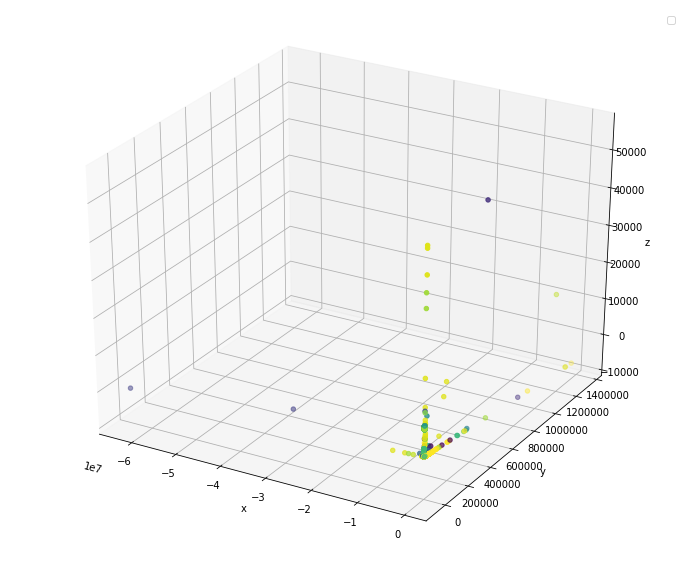

In [22]:
#plot the pca features
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

y_num_label = data['index_label']

#resultfeats[0], resultfeats[1], resultfeats[2]
xnums = [reslist[x][0] for x in range(0,len(reslist))]
ynums = [reslist[y][1] for y in range(0,len(reslist))]
znums = [reslist[z][2] for z in range(0,len(reslist))]

#resultfeats = result.show(truncate=False)
mplt = plt.figure(figsize=(12,10)).gca(projection='3d')
mplt.scatter(xnums, ynums, znums, c=y_num_label)
mplt.set_xlabel('x')
mplt.set_ylabel('y')
mplt.set_zlabel('z')
plt.legend()
plt.show()

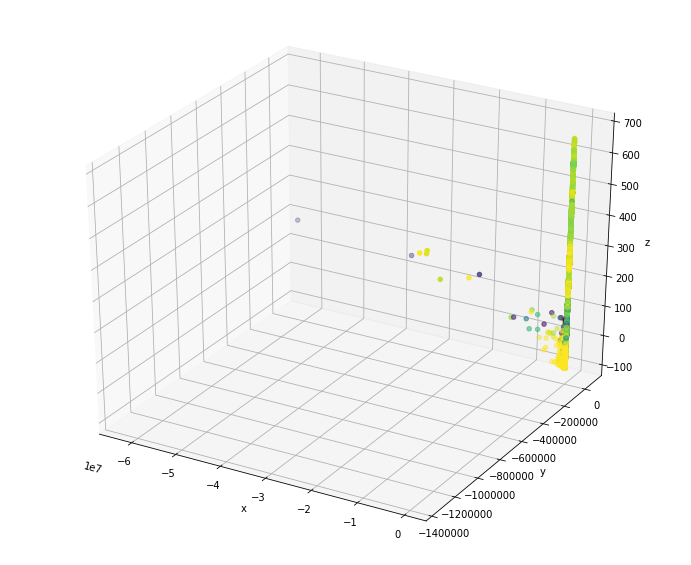

In [67]:
#plot the pca features
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

y_num_label = data[42]

#resultfeats[0], resultfeats[1], resultfeats[2]
xnums = [reslist[x][0] for x in range(0,len(reslist))]
ynums = [reslist[y][1] for y in range(0,len(reslist))]
znums = [reslist[z][2] for z in range(0,len(reslist))]

#resultfeats = result.show(truncate=False)
mplt = plt.figure(figsize=(12,10)).gca(projection='3d')
mplt.scatter(xnums, ynums, znums, c=y_num_label)
mplt.set_xlabel('x')
mplt.set_ylabel('y')
mplt.set_zlabel('z')
#plt.legend()?
plt.show()

#need to add legend